# Odd-ratio test for varying mixture weight model

Margaux Thorez

## 1- Contextualisation

Under the null hypothesis $H_0$, we have : 
$$H_0 : \Phi = \frac{\cfrac{p_1}{1 - p_1}}{\cfrac{p_2}{1 - p_2}} = \frac{\cfrac{S_1(t)}{1 - S_1(t)}}{\cfrac{S_2(t)}{1 - S_2(t)}} = 1.$$
The estimated odd-ratio is :
$$ \hat{\Phi} = \frac{\cfrac{\hat{S}_1(t)}{1 - \hat{S}_1(t)}}{\cfrac{\hat{S}_2(t)}{1 - \hat{S}_2(t)}}  $$.

For the Ryzhov model, there exists a sequence $\{ K_n , n \geq 1\}$ such that under the null hypothesis $H_0$ :
$$K_n \left(\ln(\hat{\Phi}) - \ln(\Phi)\right) \xrightarrow[n\rightarrow \infty ]{\mathcal{L}} \mathcal{N}(0,1). $$

In the case without censorship, we showed that :
$$K_n = \frac{1}{\sqrt{\frac{S_A(t)(1-S_A(t))}{n_A}\left(\frac{a_1(A)}{S_1(t)(1-S_1(t))} - \frac{a_2(A)}{S_2(t)(1-S_2(t))}\right)^2 + \frac{S_B(t)(1-S_B(t))}{n_B}\left(\frac{a_1(B)}{S_1(t)(1-S_1(t))} - \frac{a_2(B)}{S_2(t)(1-S_2(t))}\right)^2}}.$$
In the case with censorship : 
$$ K_n = \frac{1}{\sqrt{\frac{\sigma^2_A(t)}{n_A}\left(\frac{a_1(A)}{S_1(t)(1-S_1(t))} - \frac{a_2(A)}{S_2(t)(1-S_2(t))}\right)^2 + \frac{\sigma^2_B(t)}{n_B}\left(\frac{a_1(B)}{S_1(t)(1-S_1(t))} - \frac{a_2(B)}{S_2(t)(1-S_2(t))}\right)^2}},$$ 
with, for $M \in \{ A, B\}$, $\sigma^2_M(t) = S_M^2(t) \int\limits_{0}^{t} \frac{f_M(u)du}{S_M^2(u)(1-G_M(u))} $. 

We will illustrate this result with a few simulations.

## 2- Libraries import

In [1]:
#Libraries import
#Basic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from scipy import stats
import random
import statistics
import seaborn as sns

#scikit-survival Kaplan-Meier estimator
from sksurv.nonparametric import kaplan_meier_estimator

#Interpolation
from scipy.interpolate import interp1d

#CVXPY for convex optimization problems.
import cvxpy as cp

#Numba import
from numba import njit, vectorize

#Parallelization modules
from sklearn.utils._joblib import Parallel, delayed

#Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp
from scipy.stats import kstest

#Normality Test
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import norm

from scipy.integrate import quad

#Notebook
from jyquickhelper import add_notebook_menu
import warnings
warnings.filterwarnings('ignore')

In [2]:
add_notebook_menu()

## 3- Optimized functions

For the law parameter choice, we have to choose the parameter "law" among "exponnential", "pareto", "weibull" and "gamma"

### Survival functions

In [3]:
#Survival functions : returns the survival function of a mixture model for a certain law
def S(x,P1,P2,law,lambd1,lambd2):
    if law == "exponnential":
        S = P1*stats.expon.sf(x, scale=lambd1) + P2*stats.expon.sf(x, scale=lambd2)
    if law == "pareto":
        #Certain parameters of the Pareto law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.pareto.sf(x, b=3, loc = -(2/3)*lambd1, scale=(2/3)*lambd1) + P2*stats.pareto.sf(x, b=3, loc=-(2/3)*lambd2, scale=(2/3)*lambd2)
    if law == "weibull":
        #Certain parameters of the Weibull law have been fixed in order to obtain a function with characteristics similar to the survival functions found for sick leaves
        S = P1*stats.weibull_min.sf(x, c=2, scale=lambd1) + P2*stats.weibull_min.sf(x, c=2, scale=lambd2)
    if law == "gamma":
        S = P1*stats.gamma.sf(x, a=lambd1) + P2*stats.gamma.sf(x, a=lambd2)
    return(S)

### Simulation functions

In [4]:
#Function that creates the base sample in a mixture according to the chosen law
def InitializeMatriceX(law, lambd1, lambd2, P_1, size):
    #Matrices X_A1 and X_A2
    if law == "exponnential":
        X_1 = stats.expon.rvs(scale=lambd1, size=size)
        X_2 = stats.expon.rvs(scale=lambd2, size=size)
    if law == "pareto":
        X_1_v1 = stats.pareto.rvs(b=3, size=size)
        X_1 = (2/3)*lambd1*(X_1_v1-1)
        X_2_v1 = stats.pareto.rvs(b=3, size=size)
        X_2 = (2/3)*lambd2*(X_2_v1-1)
    if law == "weibull":
        X_1 = stats.weibull_min.rvs(c=2, scale=lambd1, size=size)
        X_2 = stats.weibull_min.rvs(c=2, scale=lambd2, size=size)    
    if law == "gamma" :
        X_1 = stats.gamma.rvs(a=lambd1, size=size)
        X_2 = stats.gamma.rvs(a=lambd2, size=size)
    #Matrice RA
    R = stats.bernoulli.rvs(P_1, size=size)
    X = R*X_1 + (1-R)*X_2
    return X,R

In [5]:
#Function to include censorship
@njit #(parallel=True)
def Y_ind_Allocation(Y_ind, Y, C, X):
    for i in range(len(X)):
        if Y[i]<C[i]: 
            Y_ind[i]=True
    return Y_ind

In [6]:
#Function to interpolate survival functions
def S_est_Actualisation(S_est, time, time1, t):
    S_est_res = np.concatenate(([1], S_est,[0]))
    f = interp1d(np.concatenate(([0], time,[t])), S_est_res)
    S_est_res = f(time1)
    return S_est_res

### Kaplan-Meier function of Maiboroda

In [7]:
#Function to count S_X and N_X variables for Maiboroda's estimator
@njit #(parallel=True)
def S_x_N_x_Allocation(Y,Y_ind,X_X,time):
    S_X = np.zeros_like(time)
    N_X = np.zeros_like(time)
    for k, t_k in enumerate(time):
        for i, Y_i in enumerate(Y):
            if Y_i >= t_k:
                S_X[k] += X_X[i]
            if (Y_i <= t_k) and  (Y_ind[i]==True) : 
                N_X[k] += X_X[i]
    return S_X, N_X

In [8]:
#Function to determine Maiboroda's estimator having S_X and N_X
@njit #(parallel=True)
def S_1_mx_Allocation(Y, S_X, N_X, time):
    # Initialisation
    S_1_mx = np.ones_like(time)
    for k, t_k in enumerate(time):
        for i in range(1,k):
            if (Y[i] <= t_k) and (S_X[i] != 0) :
                S_1_mx[k] = S_1_mx[k] * (1 - (N_X[i] - N_X[i-1])/S_X[i])
    return S_1_mx

In [9]:
#Function to smooth a survival function
@njit #(parallel=True)
# direction = 0 or 1
def S_1_est_mx_Threshold(S_1_est_mx, direction):
    S1_res = np.zeros_like(S_1_est_mx)
    #Maximum at 1 and minimum at 0 for the survival function
    for i, item in enumerate(S_1_est_mx):
        if item > 1 :
            S1_res[i] = 1
        elif item < 0 :
            S1_res[i] = 0
        else :
            S1_res[i] = item
    #If direction = 0, we give to S[t] the value of S[t+1] if S[t]<S[t+1]
    if direction == 0 : 
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k<len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[i] = S1_res[k]
                k+=1
    #If direction = 1, we give to S[t+1] the value of S[t] if S[t]<S[t+1]
    elif direction == 1 :
        for i in range(len(S_1_est_mx)-1):
            k = i+1
            while k < len(S_1_est_mx):
                if S1_res[i]<S1_res[k]:
                    S1_res[k] = S1_res[i]
                k+=1
    return S1_res

In [10]:
#Maiboroda's Kaplan-Meier estimator
@njit #(parallel=True)
def kaplan_meier_mx (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    return S_1_est_mx 

In [11]:
#Maiboroda's Kaplan-Meier estimator smoothed
@njit #(parallel=True)
def kaplan_meier_mx_smoothed (Y,Y_ind,X_X,time, direction) :
    #Construction of N_X and S_X
    S_X, N_X = S_x_N_x_Allocation(Y=Y,Y_ind=Y_ind,X_X=X_X,time=time)
    #Initialization of S_1_est_mx
    S_1_est_mx = S_1_mx_Allocation(Y=Y, S_X=S_X, N_X=N_X, time=time)
    #S_1_est_mx thresholding
    S_1_est_mx_res = S_1_est_mx_Threshold(S_1_est_mx, direction)
    #Return S_1_est_mx_res if we want the survival function to be linearized, S_1_est_mx otherwise
    return S_1_est_mx_res 

## 4- General case without censorship

In [12]:
def RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, M_inv, direction):
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    #Samples
    X_A,RA = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B,RB = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Kaplan-Meier estimators
    Y_A = X_A
    Y_A_ind = [True for i in range(len(Y_A))]   
    Y_B = X_B
    Y_B_ind = [True for i in range(len(Y_B))]

    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
    
    #Kaplan-Meier
    X = np.concatenate((X_A,X_B))  
    Y = X
    Y_ind = [True for i in range(len(Y))]
    
    time, S_est = kaplan_meier_estimator(Y_ind, Y)
    time = np.concatenate(([0], time))
    S_est = np.concatenate(([1], S_est))
       
    #True survival functions     
    S_1 = S(time,1,0,law,lambd1,lambd2)
    S_2 = S(time,0,1,law,lambd1,lambd2)
    
    #Odds ratio
    t = 1996
    Phi = (S_1[t]/(1-S_1[t]))/(S_2[t]/(1-S_2[t]))
    Phi_est = (S_1_est[t]/(1-S_1_est[t]))/(S_2_est[t]/(1-S_2_est[t]))
    
    KA = ((sqrt(S_A_est[t]*(1-S_A_est[t]))/sqrt(nA))*(M_inv[0][0]/(S_1_est[t]*(1-S_1_est[t])) - M_inv[1][0]/(S_2_est[t]*(1-S_2_est[t]))))
    KB = ((sqrt(S_B_est[t]*(1-S_B_est[t]))/sqrt(nB))*(M_inv[0][1]/(S_1_est[t]*(1-S_1_est[t])) - M_inv[1][1]/(S_2_est[t]*(1-S_2_est[t]))))
    
    Kn = 1/(sqrt(KA**2+KB**2))
    
    result = Kn*(np.log(Phi_est))

    return(result)


In [13]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 50

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1

In [14]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


### Results of one simulation

In [15]:
RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, M_inv, direction)

0.419900841280139

In [16]:
def RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, M_inv, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    #Initialization of parallelization parameters
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    #RunSimulation
    ComputedBlocks = ParallelSetUp([delayed(RunSimulation)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, M_inv=M_inv, direction=direction) for k in range(K)])

    #Concatenation into array
    List_results = np.array([result for result in ComputedBlocks], dtype=np.dtype(object)) # peut etre que dtype array est approprié

    #return ComputedBlocks
    return List_results

### Results of K simulations

In [17]:
#Number of repetitions
K = 1000

In [18]:
List_results = RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, M_inv, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [19]:
List_results = List_results.tolist()

Text(0.5, 1.0, 'Analytical vs. Estimated PDF of $K_n*(ln(\\hat{\\Phi}) - ln(\\Phi))$')

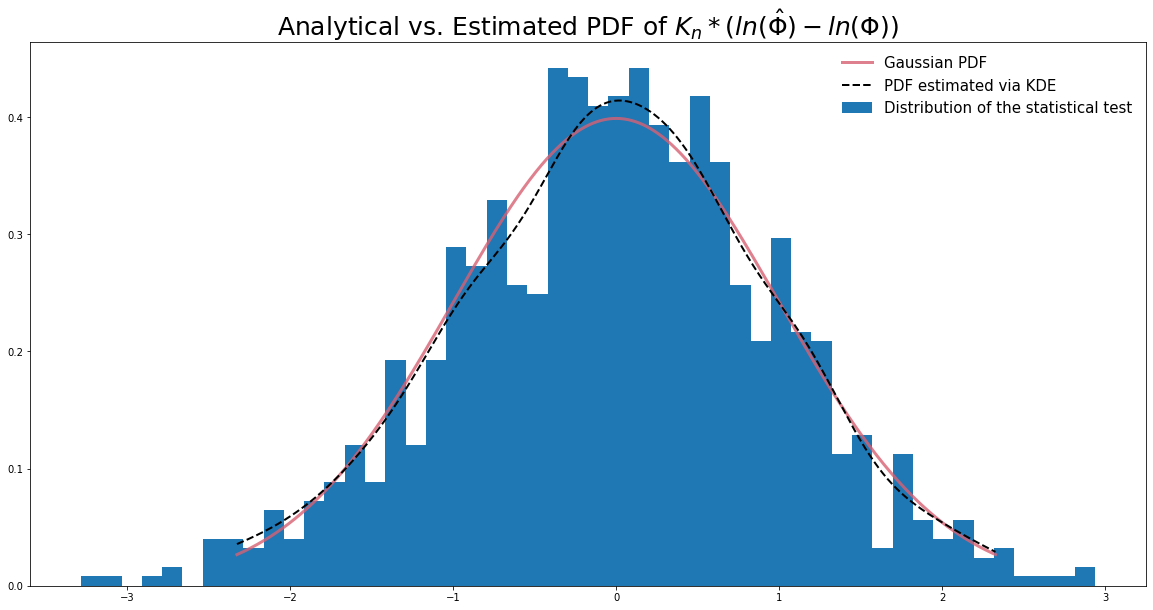

In [20]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=List_results)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(List_results,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF of $K_n*(ln(\hat{\Phi}) - ln(\Phi))$', fontsize = 25)

In [21]:
#Calculate the skewness
print(skew(List_results, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(List_results, axis=0, fisher =  False, bias=True))

-0.09931468255979656
3.066081050944858


In [22]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(List_results, 'norm')

KstestResult(statistic=0.0239471901665555, pvalue=0.6062079071654272, statistic_location=-0.3585999551715555, statistic_sign=-1)

## 5- General case with censorship

For the case with censorship, we juste take into account the exponnentiel distribution to facilitate the computation of the constant $K_n$. 

In [36]:
def RunSimulation(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, M_inv, direction):
    law = "exponnential" 
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    #Samples
    X_A,RA = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B,RB = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    C_A = stats.expon.rvs(scale=lambdC, size=nA)
    C_B = stats.expon.rvs(scale=lambdC, size=nB)
    
    #Independent copy of X_A and X_B
    Y_A = X_A
    Y_B = X_B
    #Initializing Y_A_ind and Y_B_ind
    Y_A_ind = np.full(shape=Y_A.shape, fill_value=False)
    Y_B_ind = np.full(shape=Y_B.shape, fill_value=False)
    #Updating Y_A_ind and Y_B_ind
    Y_A = np.minimum(C_A, X_A)
    Y_A_ind = Y_ind_Allocation(Y_ind=Y_A_ind, Y=Y_A, C=C_A, X=X_A)
    Y_B = np.minimum(C_B, X_B)
    Y_B_ind = Y_ind_Allocation(Y_ind=Y_B_ind, Y=Y_B, C=C_B, X=X_B)

    #Kaplan-Meier estimator
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    #Initialization of time1, t and M_inv
    time1 = np.concatenate(([0],time_A, time_B))
    time1.sort()
    t=max(time_A[-1],time_B[-1])
    #Interpolation of S_A_est and S_B_est
    S_A_est = S_est_Actualisation(S_est=S_A_est, time=time_A, time1=time1, t=t)
    S_B_est = S_est_Actualisation(S_est=S_B_est, time=time_B, time1=time1, t=t)
    #Determination of S_1_est and S_2_est (following Ryzhov's method)
    S_1_est = M_inv[0][0]*S_A_est + M_inv[0][1]*S_B_est
    S_2_est = M_inv[1][0]*S_A_est + M_inv[1][1]*S_B_est
    
    #Kaplan-Meier
    X = np.concatenate((X_A,X_B))  
    Y = X
    Y_ind = [True for i in range(len(Y))]
    
    time, S_est = kaplan_meier_estimator(Y_ind, Y)
    time = np.concatenate(([0], time))
    S_est = np.concatenate(([1], S_est))
       
    #True survival functions     
    S_1 = S(time,1,0,law,lambd1,lambd2)
    S_2 = S(time,0,1,law,lambd1,lambd2)
    
    #Odds ratio
    t = 1996
    t2 = time[t]
    
    Phi = (S_1[t]/(1-S_1[t]))/(S_2[t]/(1-S_2[t]))
    Phi_est = (S_1_est[t]/(1-S_1_est[t]))/(S_2_est[t]/(1-S_2_est[t]))
    
    #Survival function S(u)
    def S_A(u):
        return RA[t]*np.exp(-(1/lambd1) * u)  + (1-RA[t])*np.exp(-(1/lambd2) * u)
    def S_B(u):
        return RB[t]*np.exp(-(1/lambd1) * u)  + (1-RB[t])*np.exp(-(1/lambd2) * u)
    
    #Density function f(u)
    def f_A(u):
        return RA[t]*(1/lambd1) * np.exp(-(1/lambd1) * u)  + (1-RA[t])*(1/lambd2) * np.exp(-(1/lambd2) * u)
    def f_B(u):
        return RB[t]*(1/lambd1) * np.exp(-(1/lambd1) * u)  + (1-RB[t])*(1/lambd2) * np.exp(-(1/lambd2) * u)

    #Censorship function G(u)
    def G(u):
        return 1-np.exp(-(1/lambdC) * u)

    #Integral
    def integrandA(u):
        return f_A(u) / (S_A(u)**2 * (1 - G(u)))
    def integrandB(u):
        return f_B(u) / (S_B(u)**2 * (1 - G(u)))
    
    def calculate_integralA(t2):
        result, _ = quad(integrandA, 0, t2)
        return result
    def calculate_integralB(t2):
        result, _ = quad(integrandB, 0, t2)
        return result

    #Calculating the final expression
    def final_expression(t2):
        integral_valueA = calculate_integralA(t2)
        integral_valueB = calculate_integralB(t2)
        return S_A_est[t]**2 * integral_valueA, S_B_est[t]**2 * integral_valueB

    sigmaA = S_A_est[t]**2 *calculate_integralA(t2)
    sigmaB = S_B_est[t]**2 *calculate_integralB(t2)
    
    KA = ((sqrt(sigmaA)/sqrt(nA))*(M_inv[0][0]/(S_1_est[t]*(1-S_1_est[t])) - M_inv[1][0]/(S_2_est[t]*(1-S_2_est[t]))))
    KB = ((sqrt(sigmaB)/sqrt(nB))*(M_inv[0][1]/(S_1_est[t]*(1-S_1_est[t])) - M_inv[1][1]/(S_2_est[t]*(1-S_2_est[t]))))
    
    Kn = 1/(sqrt(KA**2+KB**2))
    
    result = Kn*(np.log(Phi_est))

    return(result)
    
    
    

In [37]:
def RunParallelSimulation(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, M_inv, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    #Initialization of parallelization parameters
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    #RunSimulation
    ComputedBlocks = ParallelSetUp([delayed(RunSimulation)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, lambdC=lambdC, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2, M_inv=M_inv, direction = direction) for k in range(K)])

    #Concatenation into array
    List_results = np.array([result for result in ComputedBlocks], dtype=np.dtype(object)) # peut etre que dtype array est approprié

    #return ComputedBlocks
    return List_results

### Simulation parameters

In [38]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 50

lambdC = 200

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1


In [39]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


### Results of one simulation

In [40]:
RunSimulation(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, M_inv, direction)

-0.5058619315196909

### Results of K simulations

In [41]:
#Number of repetitions
K = 1000

In [42]:
List_results = RunParallelSimulation(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, M_inv, direction, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [43]:
List_results = List_results.tolist()

Text(0.5, 1.0, 'Analytical vs. Estimated PDF of $K_n*(ln(\\hat{\\Phi}) - ln(\\Phi))$')

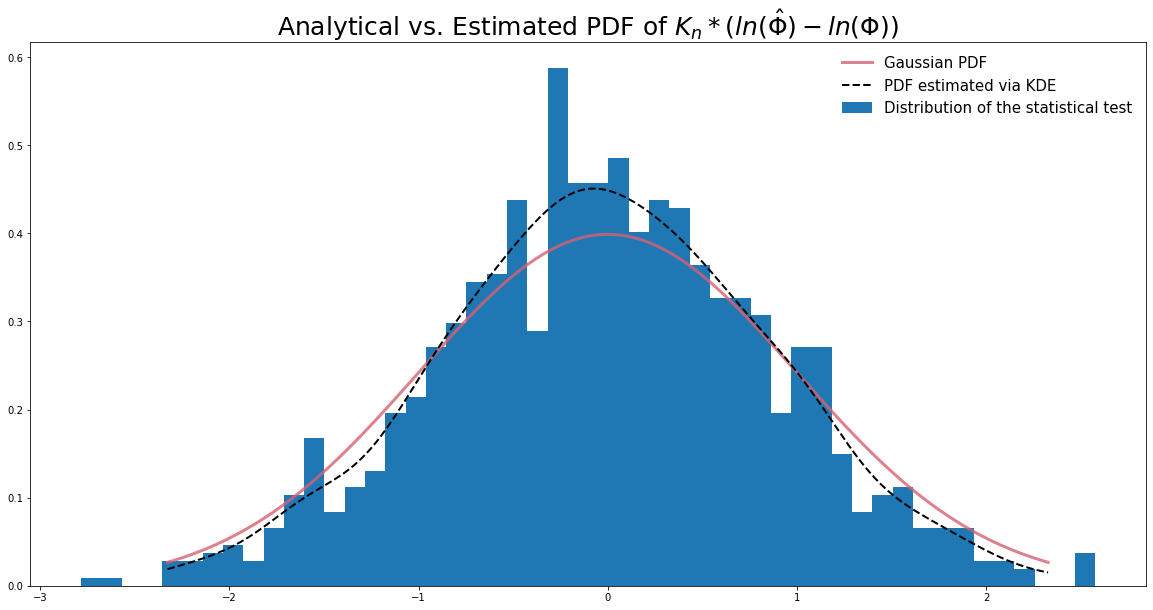

In [44]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=List_results)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(List_results,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title('Analytical vs. Estimated PDF of $K_n*(ln(\hat{\Phi}) - ln(\Phi))$', fontsize = 25)

In [45]:
#Calculate the skewness
print(skew(List_results, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(List_results, axis=0, fisher =  False, bias=True))

-0.012280609339817313
2.9462631855818793


In [46]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(List_results, 'norm')

KstestResult(statistic=0.03805554730232985, pvalue=0.10762265154174855, statistic_location=1.2209337765045523, statistic_sign=1)